# Cleaning and EDA

The categories are formatted into the final target variables.

The final text column is created by concatenating the title and abstract columns<br>

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import pickle
from plottingutils import *
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
FILE = "../data/raw.parquet.gzip"
raw_data = pd.read_parquet(FILE)

In [3]:
raw_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2190407 entries, 0 to 2190406
Data columns (total 14 columns):
 #   Column          Dtype 
---  ------          ----- 
 0   id              object
 1   submitter       object
 2   authors         object
 3   title           object
 4   comments        object
 5   journal-ref     object
 6   doi             object
 7   report-no       object
 8   categories      object
 9   license         object
 10  abstract        object
 11  versions        object
 12  update_date     object
 13  authors_parsed  object
dtypes: object(14)
memory usage: 234.0+ MB


Exploring the categories column

In [5]:
raw_data[['categories']].sample(10)

,categories
560962,math.AP math.DG
326584,astro-ph.GA
1832108,astro-ph
672392,cs.CR cs.HC
1264521,cs.CV cs.LG stat.ML
1506520,cond-mat.soft
528501,astro-ph.GA
132446,math.AG math.RT
1106898,math.CO
291968,math.AP


In [6]:
## primary category is the first one mentioned
raw_data["primary_category"] = raw_data["categories"].str.split(" ",expand=True)[0]

In [7]:
# taking out all existing categories in the dataset and creating a dataframe with a single column containing the categories
df_categories = pd.DataFrame(raw_data["categories"].str.split(" ").explode()).reset_index(drop=True)

In [8]:
# mapping them to their group name, taken from https://arxiv.org/category_taxonomy
# each group categories have an archive id, which is a prefix seprated by a "."
df_categories["archive_id"] = df_categories["categories"].str.split(".",expand=True)[0]

In [9]:
df_categories.head()

,categories,archive_id
0,hep-ph,hep-ph
1,math.CO,math
2,cs.CG,cs
3,physics.gen-ph,physics
4,math.CO,math


In [10]:
df_categories["categories"].nunique()

176

In [11]:
df_categories["categories"].describe()

count     3677349
unique        176
top        hep-ph
freq       169469
Name: categories, dtype: object

In [12]:
df_categories["archive_id"].nunique()

38

In [13]:
## df_categories is used to create df_cat manually.
## dataset of categories labels mapped to their group names created manually 
## by copy-pasting from https://arxiv.org/category_taxonomy
## some did not match any 
df_cat = pd.read_csv("categories.csv")

In [14]:
df_cat.head()

,archive_id,group_name,class_name
0,dg-ga,math,Mathematics
1,nucl-ex,ph,Physics
2,q-fin,q-fin,Quantitative Finance
3,q-alg,math,Mathematics
4,chem-ph,ph,Physics


In [15]:
## create an archive_id column for the primary_category in the data
raw_data["archive_id"] = raw_data["primary_category"].str.split(".",expand=True)[0]

In [16]:
raw_data = raw_data.merge(df_cat, how='left', on="archive_id")

In [80]:
## create data
cols_to_keep = ['id','title','abstract','class_name']
data = raw_data[cols_to_keep]

In [81]:
## Merging text and abstract columns
data["text"] = data["title"]+" "+data["abstract"]

In [82]:
## shortening class_name text for future use in charts

new_class_text = {'Economics': 'Economics',
                  'Electrical Engineering and Systems Science': 'Elec. Engin. Sys. Sc.',
                  'Physics': 'Physics',
                  'Quantitative Biology': 'Quant. Biology',
                  'Quantitative Finance': 'Quant. Finance',
                  'Statistics': 'Statistics',
                  'Computer Science': 'Computer Sc.',
                  'Mathematics': 'Mathematics'}
data["class_name"] = data["class_name"].map(new_class_text)

In [83]:
map_cats = {'Economics':0,
            'Elec. Engin. Sys. Sc.':1,
            'Physics':2,
            'Quant. Biology':3,
            'Quant. Finance':4,
            'Statistics':5,
            'Computer Sc.':6,
            'Mathematics':7}

In [84]:
data["class"] = data["class_name"].map(map_cats)

In [85]:
data.drop(['title','abstract'],axis=1,inplace=True)

In [86]:
data.head()

,id,class_name,text,class
0,0704.0001,Physics,Calculation of prompt diphoton production cros...,2
1,0704.0002,Mathematics,Sparsity-certifying Graph Decompositions We ...,7
2,0704.0003,Physics,The evolution of the Earth-Moon system based o...,2
3,0704.0004,Mathematics,A determinant of Stirling cycle numbers counts...,7
4,0704.0005,Mathematics,From dyadic $\Lambda_{\alpha}$ to $\Lambda_{\a...,7


## Class analysis

In [87]:
tab = data.groupby(['class','class_name'])['id'].count()\
    .reset_index()\
    .rename(columns={'id': 'count'})\
    .sort_values('count')

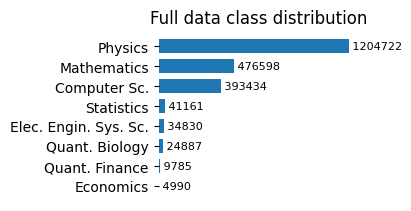

In [88]:
fig, ax = plt.subplots(figsize=(4,2), layout='constrained')

title = "Full data class distribution"
l = tab["class_name"]
w = tab["count"]
bs = .7
fs = 8
barplot(ax, labels=l, width=w, title=title,barsize=bs, font_size = fs, invert_y=False)

## Remapping classes to final target variable

In [89]:
data.rename(columns={'class':'target_extended','class_name':'target_name_extended'}, inplace=True)

data['target'] = data['target_extended'].map({2:0,7:1,6:2,5:3,1:3,3:3,4:3,0:3})
data['target_name'] = data['target_name_extended']
data.loc[data['target']==3, 'target_name'] = 'Other'

In [90]:
tab = data.groupby(['target','target_name'])['id'].count()\
    .reset_index()\
    .rename(columns={'id': 'count'})\
    .sort_values('count')

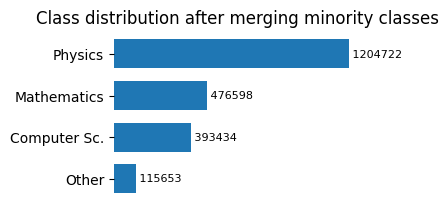

In [91]:
# import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(4,2), layout='constrained')

title = "Class distribution after merging minority classes"
l = tab["target_name"]
w = tab["count"]
bs = .7
fs = 8
barplot(ax, labels=l, width=w, title=title,barsize=bs, font_size = fs, invert_y=False)

In [92]:
## saving a map of class: class_name for future use
cat = data[["target_name", "target"]].drop_duplicates()
class_labels_dic = dict(zip(cat["target"], cat["target_name"]))
keys = sorted(class_labels_dic)
class_labels_dic = {i: class_labels_dic[i] for i in keys}
pickle.dump(class_labels_dic, open("../data/class_labels_dic.pkl", 'wb'))

Saving the data with all columns that will be used in future, before proceeding with further analysis

In [93]:
data.to_parquet("../data/data.parquet.gzip")

## Word counts

In [95]:
data['count'] = data['text'].apply(lambda x: len(x.split()))

In [101]:
def plot_counts(col, title):
    plt.figure(figsize= (8, 8))

    sns.displot(data[col])

    max_cnt = data[col].max()

    plt.xlim(0, max_cnt+10)

    plt.xlabel('Num of words ', fontsize = 16)
    plt.title(title, fontsize = 18)
    plt.show()

In [104]:
data['count'].describe().apply(round)

count    2190407
mean         148
std           65
min            4
25%           98
50%          141
75%          191
max          937
Name: count, dtype: int64

<Figure size 800x800 with 0 Axes>

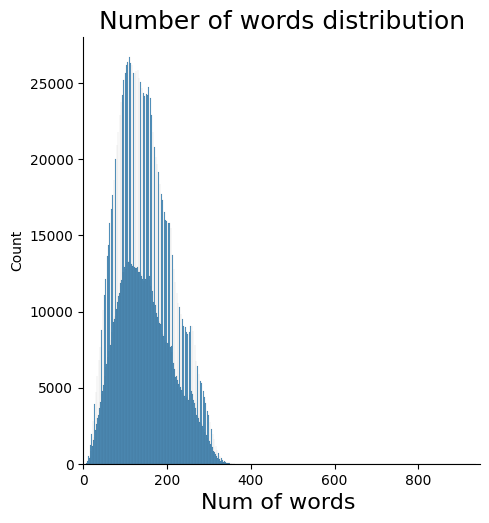

In [103]:
plot_counts('count', "Number of words distribution")